In [18]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os
from math import floor
import pandas as pd
import seaborn as sn
import datetime


#For models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as sm
from statsmodels.discrete.discrete_model import Probit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

with open('output_data/utils.p', 'rb') as f :
    utils = pickle.load(f)
G70 = utils['G70']
G90 = utils['G90']
G100 = utils['G100']
INVTHRESHOLDINT = utils['INVTHRESHOLDINT']

ventures70 = utils['ventures70']
investors70 = utils['investors70']

ventures90 = utils['ventures90']
investors90 = utils['investors90']

ventures100 = utils['ventures100']
investors100 = utils['investors100']

print(utils['description'])

■ DESCRIPTION OF UTILS 

G70 contains 71648 nodes with 46193 ventures, 128749 edges, dates, and amounts (and corrected) are edges labels.
G90 contains 87481 nodes with 55784 ventures, 165873 edges, dates, and amounts (and corrected) are edges labels.
G100 contains 92867 nodes with 58965 ventures, 180462 edges, dates, and amounts (and corrected) are edges labels.
These graphs are extracted respectively 2016, 1st semester // 2017, 2nd semester // 2017, 4th semester
INVTHRESHOLDINT is 262144 soit 2^18, if the number of the node is superior, it's an investor

Between G70 and G90, 37124 edges are created, but only 12532 are from nodes in G70
Between G90 and G100, 14589 edges are created, but only 6372 are from nodes in G90
↑ Above variables are contained in target_for_70 or _90 and target_for_70_possible and _90_possible

 It also means that there are 10^9 candidates in G70 for target


# I - Preparing Features

Here we prepare functions to calculate the different features of the Data

In [2]:
from measures_from_70_90 import dataframe_for_training, progress

# II - Preparing datasets

Here we take all candidate edges, and all target edges, and put them in a DataFrame.

the variable TARGET = 1 is to predict for target edges, 0 eitherway

## II - 1 Preparing targets for G70

In [3]:
IMBALANCE_FACTOR = 10

In [4]:
%%time
possibleTargets70 = set(utils['target_for_70_possible'])
Nt = len(possibleTargets70)
Nc = IMBALANCE_FACTOR*Nt

link_sample_not_targets70 = set()

while len(link_sample_not_targets70) < Nc :
    if not(len(link_sample_not_targets70)%100):
        progress(len(link_sample_not_targets70), Nc)
        v = np.random.choice(ventures70)
    for i in np.random.choice(investors70, size=10, replace=True) : 
        if (v,i) not in possibleTargets70 :
            link_sample_not_targets70.add((v,i))
            
Nc = len(link_sample_not_targets70)


print("\n■candidats pas target : ", Nc)
print("■targets dans 70 : ", Nt, "\n\n")

Progression :  99.2% [==================================================]

■candidats pas target :  125328
■targets dans 70 :  12532 


CPU times: user 17.8 s, sys: 391 ms, total: 18.2 s
Wall time: 17.8 s


## II - 2 Preparing targets for G90

In [5]:
%%time
possibleTargets90 = set(utils['target_for_90_possible'])
Nt = len(possibleTargets90)
Nc = IMBALANCE_FACTOR*Nt

link_sample_not_targets90 = set()

while len(link_sample_not_targets90) < Nc :
    if not(len(link_sample_not_targets90)%100):
        progress(len(link_sample_not_targets90), Nc)
        v = np.random.choice(ventures90)
    for i in np.random.choice(investors90, size=10, replace=True) : 
        if (v,i) not in possibleTargets90 :
            link_sample_not_targets90.add((v,i))
            
Nc = len(link_sample_not_targets90)


print("\n■candidats pas target : ", Nc)
print("■targets dans 90 : ", Nt, "\n\n")

Progression :  98.1% [================================================= ]

■candidats pas target :  63721
■targets dans 90 :  6372 


CPU times: user 11.5 s, sys: 188 ms, total: 11.7 s
Wall time: 11.6 s


## II - 3 Preparing dataframes
**dftrain** is for G70->G90

**dftest** is for G90->G100

In [15]:
print("These are the available features for each relations : " ,list(dftrain.columns))
selector =  "VDEGREE + IDEGREE + PREF + LVMAI + LIMAI + SHORT + LINKED + VMND + IMND".split(" + ")

These are the available features for each relations :  ['TARGET', 'VID', 'IID', 'VDEGREE', 'IDEGREE', 'VMAI', 'IMAI', 'LVMAI', 'LIMAI', 'VMND', 'IMND', 'PREF', 'SHORT', 'LINKED']


In [6]:
%%time
dftrain = dataframe_for_training(link_sample_not_targets70,possibleTargets70, G70)
dftrain = dftrain.sample(frac=1)
Xtrain, Ytrain = dftrain[selector], dftrain['TARGET']

CPU times: user 1min 19s, sys: 109 ms, total: 1min 19s
Wall time: 1min 19s


In [8]:
%%time
dftest = dataframe_for_training(link_sample_not_targets90,possibleTargets90, G90)
dftest = dftest.sample(frac=1)
Xtest, Ytest = dftest[selector], dftest['TARGET']

CPU times: user 43.2 s, sys: 31.2 ms, total: 43.2 s
Wall time: 43.2 s


# III - Different Models

### III - A : Econometrics models OLS and Probit

OLS is not good for this prediction (binary) but shows some intermediary results that are interesting. I've seen a close relation between OLS and Probit coefficients, that often are somewhat proportional.

### III - C : Further analysis for RandomForestClassifier possibilities

In [9]:
%%time
from sklearn.metrics import precision_recall_curve
rfclf = RandomForestClassifier(n_estimators= 100, max_depth=400, min_samples_leaf=2, n_jobs=6)
rfclf.fit(Xtrain,Ytrain)
y_scores = rfclf.predict_proba(Xtest)[:, 1]
p,r,thresholds = precision_recall_curve(Ytest, y_scores)


CPU times: user 36 s, sys: 375 ms, total: 36.4 s
Wall time: 6.44 s


In [10]:
%%time
from sklearn.metrics import precision_recall_curve
rfclf5 = RandomForestClassifier(n_estimators= 100, max_depth=400, min_samples_leaf=2, n_jobs=6, class_weight={0:1,1:5})
rfclf5.fit(Xtrain,Ytrain)
y_scores5 = rfclf5.predict_proba(Xtest)[:, 1]
p5,r5,thresholds5 = precision_recall_curve(Ytest, y_scores5)

CPU times: user 30 s, sys: 172 ms, total: 30.1 s
Wall time: 5.33 s


In [11]:
%%time
from sklearn.ensemble import AdaBoostClassifier
adaclf = AdaBoostClassifier()
adaclf.fit(Xtrain,Ytrain)
y_scoresADA = adaclf.predict_proba(Xtest)[:, 1]
pADA,rADA,thresholdsADA = precision_recall_curve(Ytest, y_scoresADA)

CPU times: user 3.45 s, sys: 31.2 ms, total: 3.48 s
Wall time: 3.47 s


In [12]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
grdclf = GradientBoostingClassifier()
grdclf.fit(Xtrain,Ytrain)
y_scoresGBC = grdclf.predict_proba(Xtest)[:, 1]
pGBC,rGBC,thresholdsGBC = precision_recall_curve(Ytest, y_scoresGBC)

CPU times: user 6.5 s, sys: 0 ns, total: 6.5 s
Wall time: 6.53 s


### III - D Comparison with Zheng's


■ We can see that RandomForest outperforms Zheng's
137860  % 
9.1  % of target links 


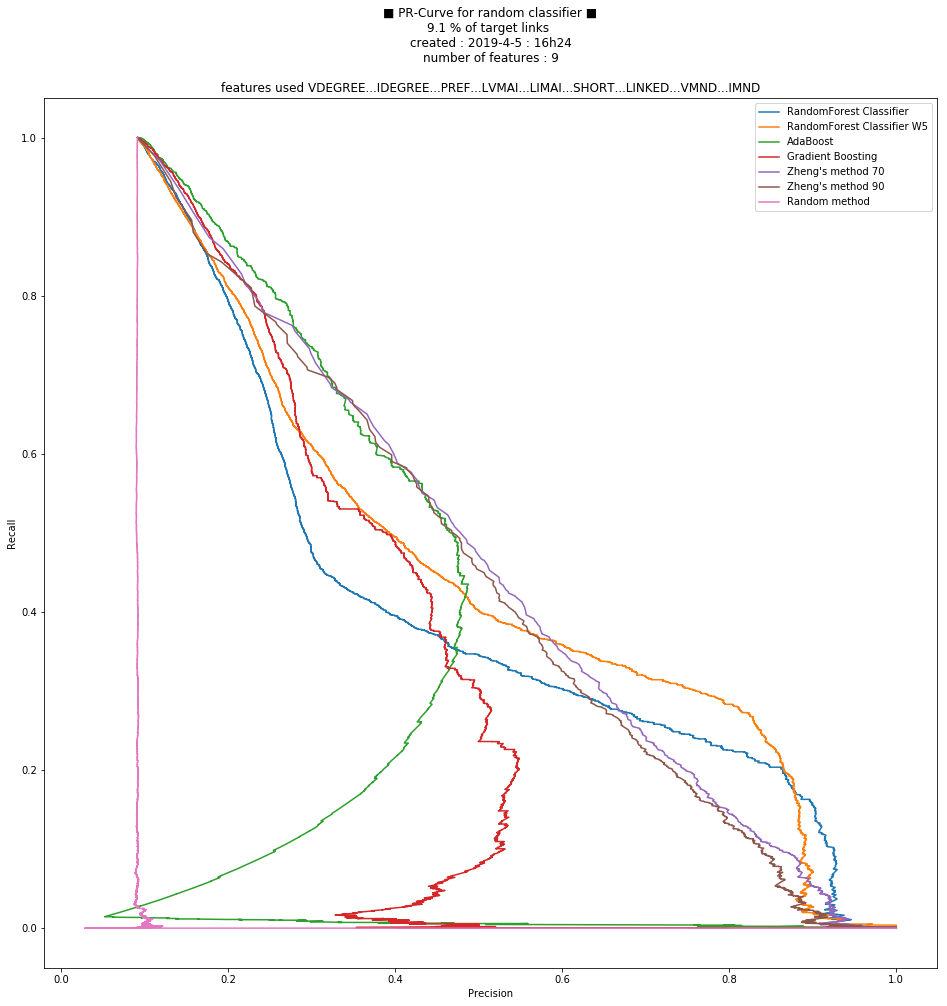

In [24]:
print("\n■ We can see that RandomForest outperforms Zheng's")
print(dftrain.shape[0], " % ")
print(round(100*dftrain['TARGET'].sum()/dftrain.shape[0],1), " % of target links ")
zhengs_scores70 = dftrain['PREF']/17226
zhengs_scores90 = dftest['PREF']/34056
comparerandomscore = np.random.rand(zhengs_scores90.shape[0])

y_scores = rfclf.predict_proba(Xtest)[:, 1]
p,r,thresholds = precision_recall_curve(Ytest, y_scores)
pZ70,rZ70,thresholdsZ70 = precision_recall_curve(Ytrain, zhengs_scores70)
pZ90,rZ90,thresholdsZ90 = precision_recall_curve(Ytest, zhengs_scores90)
pRand,rRand,thresholdsRand = precision_recall_curve(Ytest, comparerandomscore)

now = datetime.datetime.now()
plt.figure(figsize = (16,16))
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("■ PR-Curve for random classifier ■\n"
          + str(round(100*dftrain['TARGET'].sum()/dftrain.shape[0],1)) + " % of target links "
         + "\ncreated : {0}-{1}-{2} : {3}h{4}".format(now.year, now.month, now.day, now.hour, now.minute)
         + "\nnumber of features : {0}".format(len(selector))
         + "\n\nfeatures used " + "...".join(selector))
plt.plot(p, r, label="RandomForest Classifier")
plt.plot(p5, r5, label="RandomForest Classifier W5")
plt.plot(pADA,rADA, label="AdaBoost")
plt.plot(pGBC, rGBC, label="Gradient Boosting")
plt.plot(pZ70, rZ70, label='Zheng\'s method 70')
plt.plot(pZ90, rZ90, label='Zheng\'s method 90')
plt.plot(pRand,rRand, label='Random method')
plt.legend()
plt.savefig("output_data/prcurve-{0}[PERCENT:{1}]pc.png".format(now.isoformat(),str(round(100*dftrain['TARGET'].sum()/dftrain.shape[0],1)).replace(".",",") ))
plt.show()


Progression : 100.0% [==================================================]
■ Metrics for DecisionTreeClassifier (CV-grid-search) 




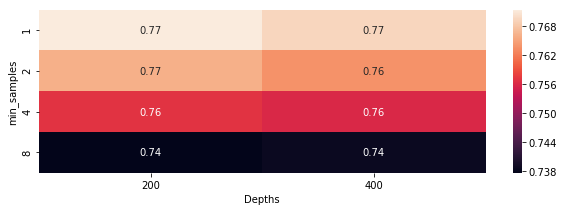

In [14]:
max_depths = [200,400]
Mmd = max_depths[-1]
min_samples = [1,2,4,8]

Nmd, Nmsf = len(max_depths), len(min_samples)

results = pd.DataFrame(np.zeros((Nmsf, Nmd)), index=min_samples, columns=max_depths)

from sklearn.metrics import fbeta_score, make_scorer
for md in max_depths:
    i=0
    for msf in min_samples:
        i+=1
        progress(md*i,Mmd*len(min_samples))
        dt_local = DecisionTreeClassifier(max_depth=md, min_samples_leaf=msf)
        dt_local.fit(Xtrain, Ytrain)
        cvscore = cross_val_score(dt_local, Xtest, Ytest, scoring=make_scorer(lambda x,y : fbeta_score(x,y,1)), n_jobs = 6, cv=10)
        results[md][msf] = cvscore.mean()

print("■ Metrics for DecisionTreeClassifier (CV-grid-search) \n\n")
plt.figure(figsize=(10,3))
sn.heatmap(results, annot=True)
plt.xlabel("Depths")
plt.ylabel("min_samples")
plt.show()